In [1]:
#Importing the necessary libraries
import io
import os
import pandas as pd
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import gensim
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
# from google.cloud import vision
# from google.cloud.vision import types

### Data Preparation
With the help of Google Vision API, we have gotten labels for all the images.

This following code takes around 35 minutes to run. We advice you skip it and go straight to task A.
!! Note !! Incase you want to run the code, please include your personal Google Vision API Key in the next cell. 

In [0]:
# Instantiates a client
client = vision.ImageAnnotatorClient.from_service_account_json('assignment4ugca-3571cda96574.json') #<Change this filename>

In [0]:
## Loading the Instagram scraped data into a dataframe.
pictures = pd.read_csv(r'Insta_scraped.csv')
pictures.head()

In [0]:
#Series of all the URLs of the Images
allurls = pictures['url']

The next cell is used to iterate through all URls. Since we have 1700 rows, it takes approximately half an hour to run.
Please skip

In [0]:
#Loop to iterate through all the URLs of the images we scraped.
#Using the script we are making requests to the Google Vision API 
#to request information from an image, such as label detection.

count = 0
for url in allurls:
    labelstring = ['']
    image = types.Image()
    
    #Our Image URL
    image.source.image_uri = url

    #Making the request
    response = client.label_detection(image=image)
    
    #Getting all the labels
    labels = response.label_annotations

    for label in labels:
        labelstring.append(label.description)

    #Saving the labels in our dataframe 
    pictures.loc[count,'labels'] = ', '.join(labelstring)
    count += 1

In [0]:
#Dropping the rows withour labels. 
dropindex = pictures[pictures['labels'] == ""].index
pictures.drop(index = dropindex, inplace=True)

In [0]:
#Saving the DataFrame into a file.
pictures.to_csv('Insta_scraped_plus_labels.csv')

In [0]:
#Reading the file for double-checking
picturelabels = pd.read_csv(r'Insta_scraped_plus_labels.csv')
picturelabels.head(20)

## Task A

In [9]:
#We are reading the DataSet with labels included from the previous step.
picturelabels = pd.read_csv(r'Insta_scraped_plus_labels.csv')
picturelabels2 = picturelabels.copy()

In [10]:
# Mormalize number of likes

maxLikes = picturelabels2['#like count'].max()
picturelabels2['#like count'] = picturelabels2['#like count']/maxLikes

#Here are the top 4 most likes Images
picturelabels2[picturelabels2['#like count']>0.85]

,Unnamed: 0,url,#like count,#comment count,caption,title,labels
568,568,https://scontent-ams4-1.cdninstagram.com/v/t51...,1.000000,13563,[{'node': {'text': 'Photo by Trevor Frost @tbf...,"Photo by Trevor Frost @tbfrost | Meet Keanu, a...",", Mammal, Vertebrate, Whiskers, Terrestrial an..."
577,577,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.891950,57081,[{'node': {'text': 'Photo by Frans Lanting @fr...,Photo by Frans Lanting @franslanting | I’m sha...,", Orangutan, Primate, Terrestrial animal, Orga..."
1241,1241,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.918598,44407,"[{'node': {'text': ""Video by Ami Vitale @amivi...",Video by Ami Vitale @amivitale | Mia and Emilk...,", Vertebrate, Rhinoceros, Mammal, White rhinoc..."
1347,1347,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.856374,14038,"[{'node': {'text': ""Photo by Charlie Hamilton ...",Photo by Charlie Hamilton James @chamiltonjame...,", Beak, Bird, Turkey Vulture, Close-up, Eye, N..."


In [11]:
#Normalize number of comments

maxComments = picturelabels2['#comment count'].max()
picturelabels2['#comment count'] = picturelabels2['#comment count']/maxComments

#Here are the top 3 most commented Images
picturelabels2[picturelabels2['#comment count']>0.78]

,Unnamed: 0,url,#like count,#comment count,caption,title,labels
408,408,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.653486,0.837852,"[{'node': {'text': ""Video by Joel Sartore @joe...",Video by Joel Sartore @joelsartore | An endang...,", Nose, Snout, Canidae, Fawn, Sporting Group, ..."
577,577,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.891950,0.957638,[{'node': {'text': 'Photo by Frans Lanting @fr...,Photo by Frans Lanting @franslanting | I’m sha...,", Orangutan, Primate, Terrestrial animal, Orga..."
1136,1136,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.429889,1.000000,[{'node': {'text': 'Video and Photos by Kirste...,Video and Photos by Kirsten Luce @kirstenluce ...,", Bengal tiger, Siberian tiger, Wildlife, Feli..."


In [12]:
# create engagment score metric using weighted like and comment counts
picturelabels2['engagement score'] = 0.4*picturelabels2['#like count'] + 0.6*picturelabels2['#comment count']

medianEngagement = picturelabels2['engagement score'].median()

# create engagement high or low classifier based on median score
picturelabels2['engagement'] = np.where(picturelabels2['engagement score'] > medianEngagement, 1, 0)
picturelabels2.head(15)

,Unnamed: 0,url,#like count,#comment count,caption,title,labels,engagement score,engagement
0,0,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.091827,0.022028,[{'node': {'text': 'Photo by @beckythale | Ove...,Photo by @beckythale | Over the course of a ye...,", Panda, Vertebrate, Mammal, Terrestrial anima...",0.049947,0
1,1,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.045626,0.003691,"[{'node': {'text': ""Photo by Simon Norfolk @si...",Photo by Simon Norfolk @simonnorfolkstudio I T...,", Architecture, Wall, Building, Stairs, Sky, W...",0.020465,0
2,2,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.079355,0.007348,"[{'node': {'text': ""Photo by @mattiasklumoffic...",Photo by @mattiasklumofficial | I felt extreme...,", Wildlife, Lycaon pictus, Terrestrial animal,...",0.036151,0
3,3,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.076537,0.027816,[{'node': {'text': 'Photo by Erika Larsen @eri...,Photo by Erika Larsen @erikalarsen888 | Christ...,", Standing, Photography, Beige, Vacation, Stre...",0.047305,0
4,4,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.078074,0.008137,"[{'node': {'text': ""Photo by Acacia Johnson @a...",Photo by Acacia Johnson @acacia.johnson | Some...,", Water, Sky, Night, Darkness, Photography, Sp...",0.036112,0
5,5,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.092814,0.008539,[{'node': {'text': 'Photo by @jasperdoest | A ...,Photo by @jasperdoest | A whooper swan in Lake...,", Ice cave, Ice, Blue, Iceberg, Natural enviro...",0.042249,0
6,6,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.071363,0.007633,[{'node': {'text': 'Photos by Pete McBride @pe...,Photos by Pete McBride @pedromcbride | Closing...,", Sky, Metropolitan area, Cityscape, Morning, ...",0.033125,0
7,7,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.078442,0.008137,"[{'node': {'text': ""Photo by @brianskerry | Th...",Photo by @brianskerry | The U.S. Civil War sub...,", Rays and skates, Fish, Underwater, Water, Ma...",0.036259,0
8,8,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.090342,0.010871,[{'node': {'text': 'Photo by William Albert Al...,Photo by William Albert Allard @williamalberta...,", Photography",0.042660,0
9,9,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.123618,0.009663,[{'node': {'text': 'Photo by David Guttenfelde...,Photo by David Guttenfelder @dguttenfelder | T...,", Badlands, Mountainous landforms, Sky, Nature...",0.055245,0


In [13]:
dataforlda = picturelabels2.copy()

## Task B

### Part 1. Logistic Regression with labels as independent variable and engagement as the dependent variable.

In [14]:
#Saving X and Y

x = picturelabels2.loc[:,'labels']
y = picturelabels2.loc[:,'engagement']

In [15]:
#Splitting into Train and Test

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [18]:
X_train.values

array([', Bathing, Bathtub, Room, Art',
       ', Blue, Textile, Pattern, Stitch, Interior design, Linens, Woven fabric',
       ', Killer whale, Marine mammal, Underwater, Cetacea, Water, Marine biology, Dolphin, Fin, Whale, Organism',
       ...,
       ', City, Town, Human settlement, Neighbourhood, Urban area, Building, Residential area, Cityscape, Metropolitan area, Photography',
       ', Sky, Nature, Arch, Star, Atmosphere, Night, Space, Astronomical object, Landscape, Rock',
       ', Performance, Musician, Music, Music artist, Performing arts, Event, Guitarist, Concert, Space, Musical instrument'],
      dtype=object)

In [19]:
#Transforming the training and testing independent variables using a TFIDF Vectorizer.
#TF-IDF BASED FEATURE REPRESENTATION

tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
tfidf_vectorizer.fit_transform(X_train.values)
        
train_labels=tfidf_vectorizer.transform(X_train.values)
test_labels=tfidf_vectorizer.transform(X_test.values)

In [21]:
train_labels.shape

(1335, 1485)

In [22]:
y_train.shape

(1335,)

In [20]:
#Building the Logistic Regression model and training it.

scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
model=scikit_log_reg.fit(train_labels,y_train)

[LibLinear]

In [11]:
#Predicting on test data using the model.

y_pred = model.predict(test_labels)
print("Accuracy Score",accuracy_score(y_pred,y_test))

Accuracy Score 0.7168539325842697


In [12]:
#This is the confusion matrix

confusion_matrix(y_test, y_pred)

array([[153,  63],
       [ 63, 166]])

### Part 2. Logistic Regression with captions as independent variable and engagement as the dependent variable.

Same as Part 1 code but with a different independent variable i.e 'Captions'

In [13]:
x = picturelabels2.loc[:,'caption']
y = picturelabels2.loc[:,'engagement']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [15]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
tfidf_vectorizer.fit_transform(X_train.values)
        
train_caption=tfidf_vectorizer.transform(X_train.values)
test_caption=tfidf_vectorizer.transform(X_test.values)

In [16]:
train_caption

<1335x14350 sparse matrix of type '<class 'numpy.float64'>'
	with 98607 stored elements in Compressed Sparse Row format>

In [17]:
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
model=scikit_log_reg.fit(train_caption,y_train)

[LibLinear]

In [18]:
y_pred = model.predict(test_caption)
print("Accuracy Score",accuracy_score(y_pred,y_test))

Accuracy Score 0.7415730337078652


In [19]:
confusion_matrix(y_test, y_pred)

array([[159,  57],
       [ 58, 171]])

### Part 3. Logistic Regression with captions as independent variable and engagement as the dependent variable.

Combining the above two Parts to get a new independent variable. Using it to make a better model.

In [20]:
picturelabels2['combined'] = picturelabels2['labels'] + picturelabels2['caption']
x = picturelabels2.loc[:,'combined']
y = picturelabels2.loc[:,'engagement']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [22]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
tfidf_vectorizer.fit_transform(X_train.values)     

train_caption=tfidf_vectorizer.transform(X_train.values)
test_caption=tfidf_vectorizer.transform(X_test.values)

In [23]:
X_train_final = np.c_[train_caption,train_labels]
X_test_final = np.hstack((test_caption,test_labels))

In [24]:
X_train_final

array([[<1335x14841 sparse matrix of type '<class 'numpy.float64'>'
	with 110733 stored elements in Compressed Sparse Row format>,
        <1335x1485 sparse matrix of type '<class 'numpy.float64'>'
	with 13753 stored elements in Compressed Sparse Row format>]],
      dtype=object)

In [25]:
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
model=scikit_log_reg.fit(train_caption,y_train)

[LibLinear]

In [26]:
y_pred = model.predict(test_caption)
print("Accuracy Score",accuracy_score(y_pred,y_test))

Accuracy Score 0.7775280898876404


In [27]:
confusion_matrix(y_test, y_pred)

array([[169,  47],
       [ 52, 177]])

## Task C.

In [28]:
dataforlda = picturelabels2.copy()
dataforlda

,Unnamed: 0,url,#like count,#comment count,caption,title,labels,engagement score,engagement,combined
0,0,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.091827,0.022028,[{'node': {'text': 'Photo by @beckythale | Ove...,Photo by @beckythale | Over the course of a ye...,", Panda, Vertebrate, Mammal, Terrestrial anima...",0.049947,0,", Panda, Vertebrate, Mammal, Terrestrial anima..."
1,1,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.045626,0.003691,"[{'node': {'text': ""Photo by Simon Norfolk @si...",Photo by Simon Norfolk @simonnorfolkstudio I T...,", Architecture, Wall, Building, Stairs, Sky, W...",0.020465,0,", Architecture, Wall, Building, Stairs, Sky, W..."
2,2,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.079355,0.007348,"[{'node': {'text': ""Photo by @mattiasklumoffic...",Photo by @mattiasklumofficial | I felt extreme...,", Wildlife, Lycaon pictus, Terrestrial animal,...",0.036151,0,", Wildlife, Lycaon pictus, Terrestrial animal,..."
3,3,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.076537,0.027816,[{'node': {'text': 'Photo by Erika Larsen @eri...,Photo by Erika Larsen @erikalarsen888 | Christ...,", Standing, Photography, Beige, Vacation, Stre...",0.047305,0,", Standing, Photography, Beige, Vacation, Stre..."
4,4,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.078074,0.008137,"[{'node': {'text': ""Photo by Acacia Johnson @a...",Photo by Acacia Johnson @acacia.johnson | Some...,", Water, Sky, Night, Darkness, Photography, Sp...",0.036112,0,", Water, Sky, Night, Darkness, Photography, Sp..."
5,5,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.092814,0.008539,[{'node': {'text': 'Photo by @jasperdoest | A ...,Photo by @jasperdoest | A whooper swan in Lake...,", Ice cave, Ice, Blue, Iceberg, Natural enviro...",0.042249,0,", Ice cave, Ice, Blue, Iceberg, Natural enviro..."
6,6,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.071363,0.007633,[{'node': {'text': 'Photos by Pete McBride @pe...,Photos by Pete McBride @pedromcbride | Closing...,", Sky, Metropolitan area, Cityscape, Morning, ...",0.033125,0,", Sky, Metropolitan area, Cityscape, Morning, ..."
7,7,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.078442,0.008137,"[{'node': {'text': ""Photo by @brianskerry | Th...",Photo by @brianskerry | The U.S. Civil War sub...,", Rays and skates, Fish, Underwater, Water, Ma...",0.036259,0,", Rays and skates, Fish, Underwater, Water, Ma..."
8,8,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.090342,0.010871,[{'node': {'text': 'Photo by William Albert Al...,Photo by William Albert Allard @williamalberta...,", Photography",0.042660,0,", Photography[{'node': {'text': 'Photo by Will..."
9,9,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.123618,0.009663,[{'node': {'text': 'Photo by David Guttenfelde...,Photo by David Guttenfelder @dguttenfelder | T...,", Badlands, Mountainous landforms, Sky, Nature...",0.055245,0,", Badlands, Mountainous landforms, Sky, Nature..."


In [29]:
#For each label which was a String, replace it with an array of labels. 

i=0
dataforlda.loc[:,'cleanlabels'] = "0"
for comment in dataforlda['labels']:
    temparray = comment.split(", ")
    dataforlda.at[i,'cleanlabels'] = temparray[1:]
    i+=1
dataforlda.head(10)

,Unnamed: 0,url,#like count,#comment count,caption,title,labels,engagement score,engagement,combined,cleanlabels
0,0,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.091827,0.022028,[{'node': {'text': 'Photo by @beckythale | Ove...,Photo by @beckythale | Over the course of a ye...,", Panda, Vertebrate, Mammal, Terrestrial anima...",0.049947,0,", Panda, Vertebrate, Mammal, Terrestrial anima...","[Panda, Vertebrate, Mammal, Terrestrial animal..."
1,1,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.045626,0.003691,"[{'node': {'text': ""Photo by Simon Norfolk @si...",Photo by Simon Norfolk @simonnorfolkstudio I T...,", Architecture, Wall, Building, Stairs, Sky, W...",0.020465,0,", Architecture, Wall, Building, Stairs, Sky, W...","[Architecture, Wall, Building, Stairs, Sky, Wo..."
2,2,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.079355,0.007348,"[{'node': {'text': ""Photo by @mattiasklumoffic...",Photo by @mattiasklumofficial | I felt extreme...,", Wildlife, Lycaon pictus, Terrestrial animal,...",0.036151,0,", Wildlife, Lycaon pictus, Terrestrial animal,...","[Wildlife, Lycaon pictus, Terrestrial animal, ..."
3,3,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.076537,0.027816,[{'node': {'text': 'Photo by Erika Larsen @eri...,Photo by Erika Larsen @erikalarsen888 | Christ...,", Standing, Photography, Beige, Vacation, Stre...",0.047305,0,", Standing, Photography, Beige, Vacation, Stre...","[Standing, Photography, Beige, Vacation, Stree..."
4,4,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.078074,0.008137,"[{'node': {'text': ""Photo by Acacia Johnson @a...",Photo by Acacia Johnson @acacia.johnson | Some...,", Water, Sky, Night, Darkness, Photography, Sp...",0.036112,0,", Water, Sky, Night, Darkness, Photography, Sp...","[Water, Sky, Night, Darkness, Photography, Spa..."
5,5,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.092814,0.008539,[{'node': {'text': 'Photo by @jasperdoest | A ...,Photo by @jasperdoest | A whooper swan in Lake...,", Ice cave, Ice, Blue, Iceberg, Natural enviro...",0.042249,0,", Ice cave, Ice, Blue, Iceberg, Natural enviro...","[Ice cave, Ice, Blue, Iceberg, Natural environ..."
6,6,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.071363,0.007633,[{'node': {'text': 'Photos by Pete McBride @pe...,Photos by Pete McBride @pedromcbride | Closing...,", Sky, Metropolitan area, Cityscape, Morning, ...",0.033125,0,", Sky, Metropolitan area, Cityscape, Morning, ...","[Sky, Metropolitan area, Cityscape, Morning, E..."
7,7,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.078442,0.008137,"[{'node': {'text': ""Photo by @brianskerry | Th...",Photo by @brianskerry | The U.S. Civil War sub...,", Rays and skates, Fish, Underwater, Water, Ma...",0.036259,0,", Rays and skates, Fish, Underwater, Water, Ma...","[Rays and skates, Fish, Underwater, Water, Man..."
8,8,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.090342,0.010871,[{'node': {'text': 'Photo by William Albert Al...,Photo by William Albert Allard @williamalberta...,", Photography",0.042660,0,", Photography[{'node': {'text': 'Photo by Will...",[Photography]
9,9,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.123618,0.009663,[{'node': {'text': 'Photo by David Guttenfelde...,Photo by David Guttenfelder @dguttenfelder | T...,", Badlands, Mountainous landforms, Sky, Nature...",0.055245,0,", Badlands, Mountainous landforms, Sky, Nature...","[Badlands, Mountainous landforms, Sky, Nature,..."


In [30]:
    
master_list = []
i=0

for comment in dataforlda['labels']:
        temparray = comment.split(", ")
        words = [word.lower() for word in temparray]

        #Remove single-character tokens (mostly punctuation)
        words = [word for word in words if len(word) > 1]
        master_list.extend(words)
    

wordfreq = FreqDist(master_list)
wordfreq
   
  

FreqDist({'sky': 552, 'water': 299, 'wildlife': 270, 'tree': 240, 'photography': 236, 'adaptation': 208, 'cloud': 193, 'vertebrate': 172, 'nature': 160, 'plant': 155, ...})

In [31]:
#Converting the Cleaned 'labels' column into a dictionary.
dictionary = gensim.corpora.Dictionary(dataforlda['cleanlabels'])

#Printing the dictionary
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 Adaptation
1 Bear
2 Carnivore
3 Fur
4 Mammal
5 Organism
6 Panda
7 Snout
8 Terrestrial animal
9 Vertebrate
10 Architecture


In [32]:
#Bag of words model uses the above dictionary to assign the key to the labels

bow_corpus = [dictionary.doc2bow(doc) for doc in dataforlda['cleanlabels']]
bow_corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1)],
 [(10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1)],
 [(2, 1), (7, 1), (8, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)],
 [(25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)],
 [(16, 1),
  (26, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1)],
 [(38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1)],
 [(12, 1),
  (16, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1)],
 [(5, 1),
  (37, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1)],
 [(26, 1)],
 [(16, 1),
  (31, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1)],
 [(5, 1),
  (37, 1),
  (57, 1),
  (59, 1),
  (63, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76,

### Topic modelling without using TFIDF 

In [33]:
#Creating a LDA model with topic = 5.
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [34]:
#These are the topic and the labels and weights associated with each of them

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"
Topic: 1 
Words: 0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"
Topic: 2 
Words: 0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"
Topic: 3 
Words: 0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0.016*"Plant" + 0.016*"Rock" + 0.013*"Formation" + 0.012*"Architecture"
Topic: 4 
Words: 0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Natur

In [35]:
#For each image we are assigning a Topic with the maximum weight amongst all the topics.
#Also we are savig the weights for each of the topics in separate columns.

i=0
for row in bow_corpus:
    ind =0
    sco =0 
    for index, score in sorted(lda_model[row], key=lambda tup: -1*tup[1]):
        if(ind ==0 and sco == 0):
            dataforlda.at[i,'Topic Final'] = index
            print("\nScore: {}\t \nTopic: {}\n{}".format(score,index,lda_model.print_topic(index, 10)))
        if(index == 0):
            dataforlda.at[i,'Topic 0']= score
        elif(index == 1):
            dataforlda.at[i,'Topic 1']= score
        elif(index == 2):
            dataforlda.at[i,'Topic 2']= score
        elif(index == 3):
            dataforlda.at[i,'Topic 3']= score
        else:
            dataforlda.at[i,'Topic 4']= score 
        ind+=1
        sco+=1 
    i+=1


Score: 0.9268903136253357	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.9258045554161072	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0.016*"Plant" + 0.016*"Rock" + 0.013*"Formation" + 0.012*"Architecture"

Score: 0.9105526208877563	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.8843742609024048	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9179352521896362	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"


Score: 0.9259783625602722	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0.016*"Plant" + 0.016*"Rock" + 0.013*"Formation" + 0.012*"Architecture"

Score: 0.7936726212501526	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.8839032053947449	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9254772067070007	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9267650246620178	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0

0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"

Score: 0.7290145754814148	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0.016*"Plant" + 0.016*"Rock" + 0.013*"Formation" + 0.012*"Architecture"

Score: 0.9259342551231384	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.48397931456565857	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.7978031635284424	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0

0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9246952533721924	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.5761406421661377	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.5013867020606995	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9270741939544678	 
Topic: 0
0.033*"W


Score: 0.7966304421424866	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"

Score: 0.8987202048301697	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.6183840036392212	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0.016*"Plant" + 0.016*"Rock" + 0.013*"Formation" + 0.012*"Architecture"

Score: 0.5558914542198181	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.8371812701225281	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" +


Score: 0.9261462688446045	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.5705170631408691	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9266344308853149	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9255280494689941	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9257615804672241	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.0


Score: 0.9255682229995728	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9262554049491882	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9252113699913025	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9262182712554932	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0.016*"Plant" + 0.016*"Rock" + 0.013*"Formation" + 0.012*"Architecture"

Score: 0.9262494444847107	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*


Score: 0.6070271730422974	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9240462779998779	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9265356659889221	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.8996908068656921	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.8840959072113037	 
Topic: 3
0.03


Score: 0.9107244610786438	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.9264281988143921	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9257218837738037	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.7290561199188232	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.925154447555542	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nat


Score: 0.7355826497077942	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.6344797611236572	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9261341691017151	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9263264536857605	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9270282983779907	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mo


Score: 0.9269934892654419	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.49015170335769653	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.926121175289154	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.6648826599121094	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.7322387099266052	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildli


Score: 0.9179307222366333	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9257671236991882	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.6548054218292236	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.924897313117981	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.8989361524581909	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.


Score: 0.6726034283638	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.7625681757926941	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0.016*"Plant" + 0.016*"Rock" + 0.013*"Formation" + 0.012*"Architecture"

Score: 0.6666025519371033	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.4850498139858246	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9270226955413818	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"


Score: 0.9249430894851685	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.927010715007782	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.926234781742096	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"

Score: 0.5007398724555969	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0.016*"Plant" + 0.016*"Rock" + 0.013*"Formation" + 0.012*"Architecture"

Score: 0.837228536605835	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife"

0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.6463040709495544	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.8831836581230164	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9250050187110901	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0.016*"Plant" + 0.016*"Rock" + 0.013*"Formation" + 0.012*"Architecture"

Score: 0.918326199054718	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural


Score: 0.7961529493331909	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9252632260322571	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9188207983970642	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"

Score: 0.8653479218482971	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0.016*"Plant" + 0.016*"Rock" + 0.013*"Formation" + 0.012*"Architecture"

Score: 0.924569547176361


Score: 0.9256943464279175	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.926692008972168	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9269261956214905	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.9259626865386963	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9257978796958923	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landsc


Score: 0.5683097839355469	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.92559814453125	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9255276918411255	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.596602737903595	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9241722226142883	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.02


Score: 0.5667255520820618	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"

Score: 0.9266997575759888	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9261512756347656	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.6437433958053589	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.7805119752883911	 
Topic: 3
0.03


Score: 0.535767674446106	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.9260809421539307	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9266345500946045	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.898526132106781	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9264890551567078	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015


Score: 0.49808165431022644	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0.016*"Plant" + 0.016*"Rock" + 0.013*"Formation" + 0.012*"Architecture"

Score: 0.9179890155792236	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9262324571609497	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9268600940704346	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0.016*"Plant" + 0.016*"Rock" + 0.013*"Formation" + 0.012*"Architecture"

Score: 0.9101797938346863	 
Topic: 3
0.033*"Sky" + 0.027*"Ad


Score: 0.9258989691734314	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.6210935711860657	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.6473345756530762	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"

Score: 0.9257230758666992	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"

Score: 0.925226092338562	 
Topi


Score: 0.9267221689224243	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"

Score: 0.9103590846061707	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.8986935615539551	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.8991202712059021	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural


Score: 0.604160726070404	 
Topic: 3
0.033*"Sky" + 0.027*"Adaptation" + 0.020*"Wildlife" + 0.019*"Tree" + 0.017*"Landscape" + 0.017*"Photography" + 0.016*"Plant" + 0.016*"Rock" + 0.013*"Formation" + 0.012*"Architecture"

Score: 0.9261272549629211	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.926602303981781	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"

Score: 0.9080219864845276	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"

Score: 0.8610731363296509	 
Topic: 0
0.033*"Wildlife" + 0.03


Score: 0.9263699054718018	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"

Score: 0.7297402024269104	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.8107967972755432	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.4976653456687927	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.9267668724060059	 
Topic: 1
0.03


Score: 0.8383476734161377	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"

Score: 0.9255849719047546	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.6451399326324463	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.9268077611923218	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"Mammal" + 0.028*"Terrestrial animal" + 0.017*"Adaptation" + 0.016*"Carnivore" + 0.014*"Organism" + 0.014*"Snout" + 0.012*"Child" + 0.012*"People"

Score: 0.5273438692092896	 
Top


Score: 0.5484282970428467	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9259619116783142	 
Topic: 4
0.037*"Sky" + 0.035*"Water" + 0.018*"Photography" + 0.016*"Cloud" + 0.015*"Sea" + 0.014*"Tree" + 0.014*"Nature" + 0.014*"Mountain" + 0.012*"Night" + 0.012*"Wildlife"

Score: 0.9092691540718079	 
Topic: 2
0.035*"Sky" + 0.018*"Mountain" + 0.015*"Water" + 0.015*"Mountainous landforms" + 0.014*"Geological phenomenon" + 0.013*"Marine mammal" + 0.012*"Landscape" + 0.012*"Rock" + 0.012*"Photography" + 0.011*"Natural landscape"

Score: 0.4950754642486572	 
Topic: 1
0.039*"Sky" + 0.019*"Tree" + 0.017*"Cloud" + 0.015*"Atmosphere" + 0.014*"Nature" + 0.014*"Water" + 0.014*"Natural landscape" + 0.013*"Natural environment" + 0.013*"Photography" + 0.012*"Atmospheric phenomenon"

Score: 0.6679151654243469	 
Topic: 0
0.033*"Wildlife" + 0.031*"Vertebrate" + 0.028*"M

In [36]:
#Please ignore
finaldata = dataforlda.sort_values(by = 'engagement score').copy()
finaldata.drop(columns = ['Unnamed: 0','title'], inplace=True)

Finding the first and 4th Quartile of the Engagement Score Data.

In [38]:
finaldata.head()

,url,#like count,#comment count,caption,labels,engagement score,engagement,combined,cleanlabels,Topic Final,Topic 0,Topic 4,Topic 3,Topic 2,Topic 1
397,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.027282,0.005973,[{'node': {'text': 'Sponsored by @tidelaundry ...,", Text, Logo, Font, Brand, Line, Design, Graph...",0.014496,0,", Text, Logo, Font, Brand, Line, Design, Graph...","[Text, Logo, Font, Brand, Line, Design, Graphi...",3.0,0.022287,0.022496,0.910208,0.022365,0.022643
369,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.033394,0.005503,"[{'node': {'text': ""Sponsored by @always_brand...",", Adaptation, Child, Education, Student, Room,...",0.016659,0,", Adaptation, Child, Education, Student, Room,...","[Adaptation, Child, Education, Student, Room, ...",1.0,0.018918,0.018462,0.018995,0.018319,0.925305
437,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.032719,0.006073,[{'node': {'text': 'Sponsored by @proctergambl...,", Photograph, Vintage clothing, Photography",0.016732,0,", Photograph, Vintage clothing, Photography[{'...","[Photograph, Vintage clothing, Photography]",4.0,0.050348,0.630978,0.050636,0.050576,0.217462
244,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.033809,0.007550,[{'node': {'text': 'See what it takes to get t...,", Mountaineering, Adventure, Mountaineer, Outd...",0.018053,0,", Mountaineering, Adventure, Mountaineer, Outd...","[Mountaineering, Adventure, Mountaineer, Outdo...",1.0,0.018293,0.018377,0.018347,0.018655,0.926327
16,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.040331,0.003808,[{'node': {'text': 'Photo and video by Camilla...,", Photograph, Snapshot, Room, Photography, Ada...",0.018417,0,", Photograph, Snapshot, Room, Photography, Ada...","[Photograph, Snapshot, Room, Photography, Adap...",3.0,0.025636,0.025735,0.672403,0.025522,0.250705


In [0]:
lowthreshold = finaldata.describe().loc['25%','engagement score']
highthreshold = finaldata.describe().loc['75%','engagement score']

In [0]:
firstquartile = finaldata[finaldata['engagement score']<=lowthreshold].copy()
firstquartile

,url,#like count,#comment count,caption,labels,engagement score,engagement,combined,cleanlabels,Topic Final,Topic 3,Topic 4,Topic 1,Topic 0,Topic 2
397,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.027282,0.005973,[{'node': {'text': 'Sponsored by @tidelaundry ...,", Text, Logo, Font, Brand, Line, Design, Graph...",0.014496,0,", Text, Logo, Font, Brand, Line, Design, Graph...","[Text, Logo, Font, Brand, Line, Design, Graphi...",0.0,0.022299,0.022248,0.022354,0.910797,0.022301
369,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.033394,0.005503,"[{'node': {'text': ""Sponsored by @always_brand...",", Adaptation, Child, Education, Student, Room,...",0.016659,0,", Adaptation, Child, Education, Student, Room,...","[Adaptation, Child, Education, Student, Room, ...",4.0,0.018215,0.926956,0.018231,0.018250,0.018347
437,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.032719,0.006073,[{'node': {'text': 'Sponsored by @proctergambl...,", Photograph, Vintage clothing, Photography",0.016732,0,", Photograph, Vintage clothing, Photography[{'...","[Photograph, Vintage clothing, Photography]",2.0,0.050147,0.051272,0.370820,0.050871,0.476890
244,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.033809,0.007550,[{'node': {'text': 'See what it takes to get t...,", Mountaineering, Adventure, Mountaineer, Outd...",0.018053,0,", Mountaineering, Adventure, Mountaineer, Outd...","[Mountaineering, Adventure, Mountaineer, Outdo...",2.0,0.018759,0.018214,0.018222,0.018244,0.926561
16,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.040331,0.003808,[{'node': {'text': 'Photo and video by Camilla...,", Photograph, Snapshot, Room, Photography, Ada...",0.018417,0,", Photograph, Snapshot, Room, Photography, Ada...","[Photograph, Snapshot, Room, Photography, Adap...",4.0,0.025145,0.898459,0.025428,0.025461,0.025507
1295,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.040608,0.004949,[{'node': {'text': 'Photo by Anastasia Taylor-...,", Roof, House, Property, Home, Building, Backy...",0.019213,0,", Roof, House, Property, Home, Building, Backy...","[Roof, House, Property, Home, Building, Backya...",3.0,0.926688,0.018218,0.018433,0.018350,0.018312
481,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.037820,0.006811,[{'node': {'text': 'Sponsored by @Charmin // W...,", People, Sari, Adaptation, Textile, Formal we...",0.019215,0,", People, Sari, Adaptation, Textile, Formal we...","[People, Sari, Adaptation, Textile, Formal wea...",4.0,0.022305,0.910708,0.022347,0.022327,0.022313
1043,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.039510,0.005704,"[{'node': {'text': ""Photo by Nina Robinson @ni...",", Artist, Art, Textile, Visual arts, T-shirt, ...",0.019226,0,", Artist, Art, Textile, Visual arts, T-shirt, ...","[Artist, Art, Textile, Visual arts, T-shirt, P...",0.0,0.028715,0.028893,0.028721,0.884824,0.028848
1,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.045626,0.003691,"[{'node': {'text': ""Photo by Simon Norfolk @si...",", Architecture, Wall, Building, Stairs, Sky, W...",0.020465,0,", Architecture, Wall, Building, Stairs, Sky, W...","[Architecture, Wall, Building, Stairs, Sky, Wo...",3.0,0.925826,0.018569,0.018458,0.018348,0.018799
402,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.043340,0.005738,"[{'node': {'text': ""Photo by @stephenwilkes //...",", Light, Visual effect lighting, Electronics, ...",0.020779,0,", Light, Visual effect lighting, Electronics, ...","[Light, Visual effect lighting, Electronics, T...",2.0,0.022500,0.022293,0.022773,0.022526,0.909908


In [0]:
fourthquartile = finaldata[finaldata['engagement score']>= highthreshold].copy()
fourthquartile

,url,#like count,#comment count,caption,labels,engagement score,engagement,combined,cleanlabels,Topic Final,Topic 3,Topic 4,Topic 1,Topic 0,Topic 2
346,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.212932,0.018236,[{'node': {'text': 'Photo by Renan Ozturk @ren...,", Polar bear, Bear, Arctic, Arctic ocean, Natu...",0.096115,1,", Polar bear, Bear, Arctic, Arctic ocean, Natu...","[Polar bear, Bear, Arctic, Arctic ocean, Natur...",3.0,0.924943,0.019606,0.018384,0.018494,0.018573
1658,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.145110,0.063551,[{'node': {'text': 'Photo by @hannahreyesmoral...,", Hair, White, Blond, Clothing, Long hair, Hai...",0.096174,1,", Hair, White, Blond, Clothing, Long hair, Hai...","[Hair, White, Blond, Clothing, Long hair, Hair...",4.0,0.018205,0.926553,0.018530,0.018293,0.018420
261,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.204825,0.023840,"[{'node': {'text': ""Photo by Jasper Doest @jas...",", Bird, Sky, Wildlife, Beak, Organism, Adaptat...",0.096234,1,", Bird, Sky, Wildlife, Beak, Organism, Adaptat...","[Bird, Sky, Wildlife, Beak, Organism, Adaptati...",0.0,0.018394,0.018475,0.018464,0.926309,0.018359
386,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.200310,0.026860,"[{'node': {'text': ""Photo by Beverly Joubert @...",", Giraffe, Terrestrial animal, Giraffidae, Ver...",0.096240,1,", Giraffe, Terrestrial animal, Giraffidae, Ver...","[Giraffe, Terrestrial animal, Giraffidae, Vert...",3.0,0.926183,0.018518,0.018420,0.018578,0.018301
1450,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.204883,0.023924,"[{'node': {'text': ""Photo by @michaelchristoph...",", Geological phenomenon, Heat, Fire, Volcano, ...",0.096308,1,", Geological phenomenon, Heat, Fire, Volcano, ...","[Geological phenomenon, Heat, Fire, Volcano, F...",2.0,0.018532,0.018237,0.018405,0.018448,0.926378
377,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.194886,0.031306,[{'node': {'text': 'Photo by Steve Winter @ste...,", Ice, Sky, Water, Glacial landform, Winter, F...",0.096738,1,", Ice, Sky, Water, Glacial landform, Winter, F...","[Ice, Sky, Water, Glacial landform, Winter, Fr...",3.0,0.926362,0.018286,0.018400,0.018493,0.018460
706,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.192533,0.032933,[{'node': {'text': 'Photo by Diana Markosian @...,", Mountainous landforms, Mountain, Highland, S...",0.096773,1,", Mountainous landforms, Mountain, Highland, S...","[Mountainous landforms, Mountain, Highland, Sp...",0.0,0.232048,0.018432,0.019136,0.711702,0.018682
69,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.185291,0.037781,"[{'node': {'text': ""Video by Paul Nicklen @pau...",", Marine biology, Fish, Fin, Underwater, Fish,...",0.096785,1,", Marine biology, Fish, Fin, Underwater, Fish,...","[Marine biology, Fish, Fin, Underwater, Fish, ...",1.0,0.018282,0.018286,0.926818,0.018365,0.018248
769,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.211622,0.020719,[{'node': {'text': 'Photo by Drew Rush @drewtr...,", Snow, Wildlife, Winter, Grizzly bear, Brown ...",0.097081,1,", Snow, Wildlife, Winter, Grizzly bear, Brown ...","[Snow, Wildlife, Winter, Grizzly bear, Brown b...",3.0,0.925920,0.018372,0.018689,0.018568,0.018451
142,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.163912,0.052629,"[{'node': {'text': ""Photo by Mattias Klum @mat...",", Reptile, Scaled reptile, Snake, Organism, Te...",0.097142,1,", Reptile, Scaled reptile, Snake, Organism, Te...","[Reptile, Scaled reptile, Snake, Organism, Ter...",1.0,0.018370,0.018720,0.754746,0.189512,0.018651


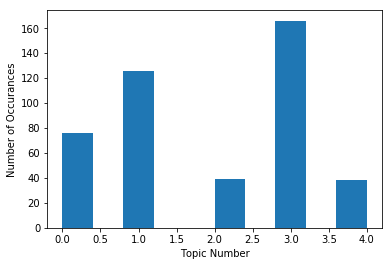

In [0]:
#Plotting the Topic vs. Frequency of Occurance in the 4th Quartile
#This is where the engagement score is the maximum. 

plt.ylabel("Number of Occurances")
plt.xlabel("Topic Number")
plt.hist(fourthquartile['Topic Final'])
plt.show()

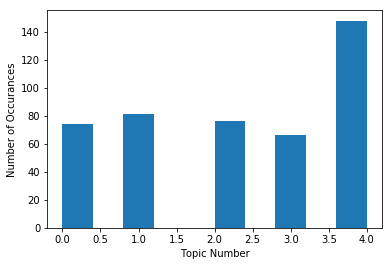

In [0]:
#Plotting the Topic vs. Frequency of Occurance in the 1st Quartile
#This is where the engagement score is the minimum. 

plt.ylabel("Number of Occurances")
plt.xlabel("Topic Number")
plt.hist(firstquartile['Topic Final'])
plt.show()

## Task D.
### Analysis

In [0]:
analysis = picturelabels2.copy()
analysisfilter = analysis.loc[:,['caption','labels','engagement score']]
analysisfilter.sort_values(by = 'engagement score').head(10)

,caption,labels,engagement score
397,[{'node': {'text': 'Sponsored by @tidelaundry ...,", Text, Logo, Font, Brand, Line, Design, Graph...",0.014496
369,"[{'node': {'text': ""Sponsored by @always_brand...",", Adaptation, Child, Education, Student, Room,...",0.016659
437,[{'node': {'text': 'Sponsored by @proctergambl...,", Photograph, Vintage clothing, Photography",0.016732
244,[{'node': {'text': 'See what it takes to get t...,", Mountaineering, Adventure, Mountaineer, Outd...",0.018053
16,[{'node': {'text': 'Photo and video by Camilla...,", Photograph, Snapshot, Room, Photography, Ada...",0.018417
1295,[{'node': {'text': 'Photo by Anastasia Taylor-...,", Roof, House, Property, Home, Building, Backy...",0.019213
481,[{'node': {'text': 'Sponsored by @Charmin // W...,", People, Sari, Adaptation, Textile, Formal we...",0.019215
1043,"[{'node': {'text': ""Photo by Nina Robinson @ni...",", Artist, Art, Textile, Visual arts, T-shirt, ...",0.019226
1,"[{'node': {'text': ""Photo by Simon Norfolk @si...",", Architecture, Wall, Building, Stairs, Sky, W...",0.020465
402,"[{'node': {'text': ""Photo by @stephenwilkes //...",", Light, Visual effect lighting, Electronics, ...",0.020779


In [0]:
analysisfilter.sort_values(by = 'engagement score').tail(15)

,caption,labels,engagement score
1242,[{'node': {'text': 'Photos by Kirsten Luce @ki...,", Reptile, Metal",0.330499
883,[{'node': {'text': 'Video and photos by Babak ...,", Sky, Black, Night, Atmospheric phenomenon, S...",0.332650
1156,"[{'node': {'text': ""Photos by Kirsten Luce @ki...",", Elephants and Mammoths, Elephant, Mammal, In...",0.339087
879,[{'node': {'text': 'Photo by Ami Vitale @amivi...,", Giraffe, Terrestrial animal, Giraffidae, Mam...",0.346847
1184,[{'node': {'text': 'Photo by Ken Geiger @kenge...,", Lion, Wildlife, Felidae, Big cats, Sky, Carn...",0.377945
215,[{'node': {'text': 'Photo by Paul Nicklen @pau...,", Underwater, Water, Recreation, Fun, Underwat...",0.381378
1218,[{'node': {'text': 'Photos by Kirsten Luce @ki...,", Vertebrate, Bear, Polar bear, Mammal, Terres...",0.394800
1428,[{'node': {'text': 'Photos by Tim Laman @timla...,", Leaf, Botany, Headgear, Organism, Terrestria...",0.400931
1347,"[{'node': {'text': ""Photo by Charlie Hamilton ...",", Beak, Bird, Turkey Vulture, Close-up, Eye, N...",0.483857
568,[{'node': {'text': 'Photo by Trevor Frost @tbf...,", Mammal, Vertebrate, Whiskers, Terrestrial an...",0.536527


Here are few recommendations and insights we would give National Geographic in order to increase their engagement score.

<b><u>Task B Insights:</b></u>
1. Predicting Engagement on Captions is more accurate than predicting engagement on Image Labels we got from Google.
2. Predicting Engagement score using a combination of captions and labels proves to be the most accurate way of predicting the engagement of the Post.
3. If you look at the images with the lowest engagement, the majority of them are sponsored Posts. We can therefore conclude that sponsored images will result in lesser engagement in general.
4. If you look at the images with the highest engagement, nearly all of them contain labels of nature, especially animals. Interesting to note that 'humans' are not part of any of these Posts.
5. Combining the insights of both of the above, we advice Nat Geo to include as much Nature and Animals as they can in their sponsored posts. Humans and Artificially created objects will not result in a good enagagement score.

<b><u>Task C Insights:</b></u>
1. Looking at both the histograms from Task C, we can clearly observe that the Posts in the highest quartile of the engagement score have a higher occurence of labels in Topic X. Moreover, the posts in the lowers quartile of engagement have the lowest occurence of labels in Topic X.
2. Here the Value of X changes as per our Topic. In our case it was 3. It maybe different when you run the code. 

<b>Topic X - With Highest Engagement: 
<p>Wildlife, Vertebrate, Adaptation, Terrestrial animal, Mammal, Organism, Snout, Water, Photography, Plant</p></b>

3. Also, we can observe that the Posts in the highest quartile of the engagement score have a least occurence of labels in Topic Y. Moreover, the posts in the lowers quartile of engagement have the highest occurence of labels in Topic Y.
4. Here the Value of Y changes as per our Topic. In our case it was 0. It maybe different when you run the code.

<b>Topic Y - with Lowest Engagement:
<p>Photography, Human, Room, Marine biology, Art, Fish, Underwater, Architecture, Child, Adaptation</b></p>

4. We would suggest Nat Geo to post more Images and Videos with content that relates to the the above Topic X and stay away from labels that relate to Topic Y. Especially try including Topic X related posts in your Sponsored section, conversely avoid including Topic Y labels in the Sponsored.

5. You can verify our Task B analysis where we concluded that animal ft. content leads to higher engagement and humans ft. content leads to much lower engagement. Please look at Topic X and Topic Y.

<i>Oh! The Humanity!</i>
<h2 align = "center"> Le Fin.</h2>



### Addendum: Extra 
Below is the topic modelling using TFIDF and LDA. This is something extra we tried to get a better results. Unfortunately we didn't get as good a result as the above. We still thought this was an interesting attempt which is why we've left it here.

In [0]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.192662122017803),
 (1, 0.3864598184926075),
 (2, 0.27954104047898415),
 (3, 0.40282182610389183),
 (4, 0.23079223770907603),
 (5, 0.23347131975984248),
 (6, 0.5472569430269917),
 (7, 0.27088444694555436),
 (8, 0.2202220837471512),
 (9, 0.209717125998716)]


In [0]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=6, id2word=dictionary, passes=2, workers=4) #Thank you Susan.
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWord: {}\n'.format(idx, topic))

Topic: 0 
Word: 0.010*"Landscape" + 0.008*"Geology" + 0.008*"Photography" + 0.008*"Rock" + 0.007*"Formation" + 0.007*"Soil" + 0.007*"Tree" + 0.006*"Geological phenomenon" + 0.006*"Sky" + 0.005*"Aerial photography"

Topic: 1 
Word: 0.014*"Wildlife" + 0.013*"Terrestrial animal" + 0.011*"Vertebrate" + 0.010*"Mammal" + 0.008*"Grassland" + 0.008*"Black-and-white" + 0.008*"Sky" + 0.007*"Monochrome" + 0.007*"Elephant" + 0.007*"Elephants and Mammoths"

Topic: 2 
Word: 0.011*"Adaptation" + 0.009*"Sky" + 0.009*"Tree" + 0.009*"Photography" + 0.009*"Nature" + 0.008*"Mountain" + 0.008*"Plant" + 0.008*"Wildlife" + 0.008*"Water" + 0.008*"Human"

Topic: 3 
Word: 0.012*"Fish" + 0.012*"Underwater" + 0.011*"Marine biology" + 0.011*"Organism" + 0.011*"Atmosphere" + 0.009*"Water" + 0.009*"Space" + 0.009*"Night" + 0.008*"Sky" + 0.008*"Astronomical object"

Topic: 4 
Word: 0.010*"Mountain range" + 0.010*"Mountain" + 0.010*"Mountainous landforms" + 0.008*"Summit" + 0.007*"Ridge" + 0.007*"Alps" + 0.007*"Art" +

In [0]:
i=0
for row in bow_corpus:
    ind =0
    sco =0 
    for index, score in sorted(lda_model_tfidf[row], key=lambda tup: -1*tup[1]):
        if(ind ==0 and sco == 0):
            dataforlda.at[i,'Topic Final'] = index
            print("\nScore: {}\t \nTopic: {}\n{}".format(score,index,lda_model_tfidf.print_topic(index, 10)))
        if(index == 0):
            dataforlda.at[i,'Topic 0']= score
        elif(index == 1):
            dataforlda.at[i,'Topic 1']= score
        elif(index == 2):
            dataforlda.at[i,'Topic 2']= score
        elif(index == 3):
            dataforlda.at[i,'Topic 3']= score
        elif(index == 4):
            dataforlda.at[i,'Topic 4']= score
        elif(index == 5):
            dataforlda.at[i,'Topic 5']= score
        elif(index == 6):
            dataforlda.at[i,'Topic 6']= score
#         elif(index == 7):
#             dataforlda.at[i,'Topic 7']= score
#         elif(index == 8):
#             dataforlda.at[i,'Topic 8']= score
#         elif(index == 9):
#             dataforlda.at[i,'Topic 9']= score 
        ind+=1
        sco+=1 
    i+=1


Score: 0.6632002592086792	 
Topic: 1
0.014*"Wildlife" + 0.013*"Terrestrial animal" + 0.011*"Vertebrate" + 0.010*"Mammal" + 0.008*"Grassland" + 0.008*"Black-and-white" + 0.008*"Sky" + 0.007*"Monochrome" + 0.007*"Elephant" + 0.007*"Elephants and Mammoths"

Score: 0.923647940158844	 
Topic: 4
0.010*"Mountain range" + 0.010*"Mountain" + 0.010*"Mountainous landforms" + 0.008*"Summit" + 0.007*"Ridge" + 0.007*"Alps" + 0.007*"Art" + 0.007*"Sky" + 0.006*"Geological phenomenon" + 0.006*"Building"

Score: 0.9070827960968018	 
Topic: 1
0.014*"Wildlife" + 0.013*"Terrestrial animal" + 0.011*"Vertebrate" + 0.010*"Mammal" + 0.008*"Grassland" + 0.008*"Black-and-white" + 0.008*"Sky" + 0.007*"Monochrome" + 0.007*"Elephant" + 0.007*"Elephants and Mammoths"

Score: 0.8790110349655151	 
Topic: 1
0.014*"Wildlife" + 0.013*"Terrestrial animal" + 0.011*"Vertebrate" + 0.010*"Mammal" + 0.008*"Grassland" + 0.008*"Black-and-white" + 0.008*"Sky" + 0.007*"Monochrome" + 0.007*"Elephant" + 0.007*"Elephants and Mammoth


Score: 0.9240321516990662	 
Topic: 5
0.014*"Cloud" + 0.014*"Horizon" + 0.013*"Sky" + 0.012*"Water" + 0.012*"Sea" + 0.011*"Tourism" + 0.010*"Evening" + 0.009*"Ocean" + 0.009*"Reflection" + 0.008*"Blue"

Score: 0.9067354798316956	 
Topic: 2
0.011*"Adaptation" + 0.009*"Sky" + 0.009*"Tree" + 0.009*"Photography" + 0.009*"Nature" + 0.008*"Mountain" + 0.008*"Plant" + 0.008*"Wildlife" + 0.008*"Water" + 0.008*"Human"

Score: 0.7200143337249756	 
Topic: 2
0.011*"Adaptation" + 0.009*"Sky" + 0.009*"Tree" + 0.009*"Photography" + 0.009*"Nature" + 0.008*"Mountain" + 0.008*"Plant" + 0.008*"Wildlife" + 0.008*"Water" + 0.008*"Human"

Score: 0.7171109914779663	 
Topic: 5
0.014*"Cloud" + 0.014*"Horizon" + 0.013*"Sky" + 0.012*"Water" + 0.012*"Sea" + 0.011*"Tourism" + 0.010*"Evening" + 0.009*"Ocean" + 0.009*"Reflection" + 0.008*"Blue"

Score: 0.700040876865387	 
Topic: 2
0.011*"Adaptation" + 0.009*"Sky" + 0.009*"Tree" + 0.009*"Photography" + 0.009*"Nature" + 0.008*"Mountain" + 0.008*"Plant" + 0.008*"Wildli

0.011*"Adaptation" + 0.009*"Sky" + 0.009*"Tree" + 0.009*"Photography" + 0.009*"Nature" + 0.008*"Mountain" + 0.008*"Plant" + 0.008*"Wildlife" + 0.008*"Water" + 0.008*"Human"

Score: 0.634202778339386	 
Topic: 2
0.011*"Adaptation" + 0.009*"Sky" + 0.009*"Tree" + 0.009*"Photography" + 0.009*"Nature" + 0.008*"Mountain" + 0.008*"Plant" + 0.008*"Wildlife" + 0.008*"Water" + 0.008*"Human"

Score: 0.9240309596061707	 
Topic: 0
0.010*"Landscape" + 0.008*"Geology" + 0.008*"Photography" + 0.008*"Rock" + 0.007*"Formation" + 0.007*"Soil" + 0.007*"Tree" + 0.006*"Geological phenomenon" + 0.006*"Sky" + 0.005*"Aerial photography"

Score: 0.48412594199180603	 
Topic: 1
0.014*"Wildlife" + 0.013*"Terrestrial animal" + 0.011*"Vertebrate" + 0.010*"Mammal" + 0.008*"Grassland" + 0.008*"Black-and-white" + 0.008*"Sky" + 0.007*"Monochrome" + 0.007*"Elephant" + 0.007*"Elephants and Mammoths"

Score: 0.8953936696052551	 
Topic: 5
0.014*"Cloud" + 0.014*"Horizon" + 0.013*"Sky" + 0.012*"Water" + 0.012*"Sea" + 0.011*"To


Score: 0.924075186252594	 
Topic: 1
0.014*"Wildlife" + 0.013*"Terrestrial animal" + 0.011*"Vertebrate" + 0.010*"Mammal" + 0.008*"Grassland" + 0.008*"Black-and-white" + 0.008*"Sky" + 0.007*"Monochrome" + 0.007*"Elephant" + 0.007*"Elephants and Mammoths"

Score: 0.923639178276062	 
Topic: 3
0.012*"Fish" + 0.012*"Underwater" + 0.011*"Marine biology" + 0.011*"Organism" + 0.011*"Atmosphere" + 0.009*"Water" + 0.009*"Space" + 0.009*"Night" + 0.008*"Sky" + 0.008*"Astronomical object"

Score: 0.5640986561775208	 
Topic: 3
0.012*"Fish" + 0.012*"Underwater" + 0.011*"Marine biology" + 0.011*"Organism" + 0.011*"Atmosphere" + 0.009*"Water" + 0.009*"Space" + 0.009*"Night" + 0.008*"Sky" + 0.008*"Astronomical object"

Score: 0.587346613407135	 
Topic: 3
0.012*"Fish" + 0.012*"Underwater" + 0.011*"Marine biology" + 0.011*"Organism" + 0.011*"Atmosphere" + 0.009*"Water" + 0.009*"Space" + 0.009*"Night" + 0.008*"Sky" + 0.008*"Astronomical object"

Score: 0.6513172388076782	 
Topic: 0
0.010*"Landscape" + 0.0


Score: 0.7906705737113953	 
Topic: 5
0.014*"Cloud" + 0.014*"Horizon" + 0.013*"Sky" + 0.012*"Water" + 0.012*"Sea" + 0.011*"Tourism" + 0.010*"Evening" + 0.009*"Ocean" + 0.009*"Reflection" + 0.008*"Blue"

Score: 0.9237279295921326	 
Topic: 2
0.011*"Adaptation" + 0.009*"Sky" + 0.009*"Tree" + 0.009*"Photography" + 0.009*"Nature" + 0.008*"Mountain" + 0.008*"Plant" + 0.008*"Wildlife" + 0.008*"Water" + 0.008*"Human"

Score: 0.9239773154258728	 
Topic: 3
0.012*"Fish" + 0.012*"Underwater" + 0.011*"Marine biology" + 0.011*"Organism" + 0.011*"Atmosphere" + 0.009*"Water" + 0.009*"Space" + 0.009*"Night" + 0.008*"Sky" + 0.008*"Astronomical object"

Score: 0.9239144921302795	 
Topic: 3
0.012*"Fish" + 0.012*"Underwater" + 0.011*"Marine biology" + 0.011*"Organism" + 0.011*"Atmosphere" + 0.009*"Water" + 0.009*"Space" + 0.009*"Night" + 0.008*"Sky" + 0.008*"Astronomical object"

Score: 0.9236010313034058	 
Topic: 3
0.012*"Fish" + 0.012*"Underwater" + 0.011*"Marine biology" + 0.011*"Organism" + 0.011*"Atmo


Score: 0.5664241313934326	 
Topic: 1
0.014*"Wildlife" + 0.013*"Terrestrial animal" + 0.011*"Vertebrate" + 0.010*"Mammal" + 0.008*"Grassland" + 0.008*"Black-and-white" + 0.008*"Sky" + 0.007*"Monochrome" + 0.007*"Elephant" + 0.007*"Elephants and Mammoths"

Score: 0.879616379737854	 
Topic: 0
0.010*"Landscape" + 0.008*"Geology" + 0.008*"Photography" + 0.008*"Rock" + 0.007*"Formation" + 0.007*"Soil" + 0.007*"Tree" + 0.006*"Geological phenomenon" + 0.006*"Sky" + 0.005*"Aerial photography"

Score: 0.9236953854560852	 
Topic: 2
0.011*"Adaptation" + 0.009*"Sky" + 0.009*"Tree" + 0.009*"Photography" + 0.009*"Nature" + 0.008*"Mountain" + 0.008*"Plant" + 0.008*"Wildlife" + 0.008*"Water" + 0.008*"Human"

Score: 0.7529259324073792	 
Topic: 1
0.014*"Wildlife" + 0.013*"Terrestrial animal" + 0.011*"Vertebrate" + 0.010*"Mammal" + 0.008*"Grassland" + 0.008*"Black-and-white" + 0.008*"Sky" + 0.007*"Monochrome" + 0.007*"Elephant" + 0.007*"Elephants and Mammoths"

Score: 0.4723081588745117	 
Topic: 1
0.014*


Score: 0.8601849675178528	 
Topic: 0
0.010*"Landscape" + 0.008*"Geology" + 0.008*"Photography" + 0.008*"Rock" + 0.007*"Formation" + 0.007*"Soil" + 0.007*"Tree" + 0.006*"Geological phenomenon" + 0.006*"Sky" + 0.005*"Aerial photography"

Score: 0.521949827671051	 
Topic: 2
0.011*"Adaptation" + 0.009*"Sky" + 0.009*"Tree" + 0.009*"Photography" + 0.009*"Nature" + 0.008*"Mountain" + 0.008*"Plant" + 0.008*"Wildlife" + 0.008*"Water" + 0.008*"Human"

Score: 0.7216781377792358	 
Topic: 2
0.011*"Adaptation" + 0.009*"Sky" + 0.009*"Tree" + 0.009*"Photography" + 0.009*"Nature" + 0.008*"Mountain" + 0.008*"Plant" + 0.008*"Wildlife" + 0.008*"Water" + 0.008*"Human"

Score: 0.7689677476882935	 
Topic: 1
0.014*"Wildlife" + 0.013*"Terrestrial animal" + 0.011*"Vertebrate" + 0.010*"Mammal" + 0.008*"Grassland" + 0.008*"Black-and-white" + 0.008*"Sky" + 0.007*"Monochrome" + 0.007*"Elephant" + 0.007*"Elephants and Mammoths"

Score: 0.7486744523048401	 
Topic: 0
0.010*"Landscape" + 0.008*"Geology" + 0.008*"Photo

0.014*"Cloud" + 0.014*"Horizon" + 0.013*"Sky" + 0.012*"Water" + 0.012*"Sea" + 0.011*"Tourism" + 0.010*"Evening" + 0.009*"Ocean" + 0.009*"Reflection" + 0.008*"Blue"

Score: 0.5186655521392822	 
Topic: 3
0.012*"Fish" + 0.012*"Underwater" + 0.011*"Marine biology" + 0.011*"Organism" + 0.011*"Atmosphere" + 0.009*"Water" + 0.009*"Space" + 0.009*"Night" + 0.008*"Sky" + 0.008*"Astronomical object"

Score: 0.8956029415130615	 
Topic: 0
0.010*"Landscape" + 0.008*"Geology" + 0.008*"Photography" + 0.008*"Rock" + 0.007*"Formation" + 0.007*"Soil" + 0.007*"Tree" + 0.006*"Geological phenomenon" + 0.006*"Sky" + 0.005*"Aerial photography"

Score: 0.9234919548034668	 
Topic: 3
0.012*"Fish" + 0.012*"Underwater" + 0.011*"Marine biology" + 0.011*"Organism" + 0.011*"Atmosphere" + 0.009*"Water" + 0.009*"Space" + 0.009*"Night" + 0.008*"Sky" + 0.008*"Astronomical object"

Score: 0.7211933732032776	 
Topic: 3
0.012*"Fish" + 0.012*"Underwater" + 0.011*"Marine biology" + 0.011*"Organism" + 0.011*"Atmosphere" + 0.0

0.010*"Mountain range" + 0.010*"Mountain" + 0.010*"Mountainous landforms" + 0.008*"Summit" + 0.007*"Ridge" + 0.007*"Alps" + 0.007*"Art" + 0.007*"Sky" + 0.006*"Geological phenomenon" + 0.006*"Building"

Score: 0.5840721130371094	 
Topic: 3
0.012*"Fish" + 0.012*"Underwater" + 0.011*"Marine biology" + 0.011*"Organism" + 0.011*"Atmosphere" + 0.009*"Water" + 0.009*"Space" + 0.009*"Night" + 0.008*"Sky" + 0.008*"Astronomical object"

Score: 0.895148754119873	 
Topic: 2
0.011*"Adaptation" + 0.009*"Sky" + 0.009*"Tree" + 0.009*"Photography" + 0.009*"Nature" + 0.008*"Mountain" + 0.008*"Plant" + 0.008*"Wildlife" + 0.008*"Water" + 0.008*"Human"

Score: 0.9241151809692383	 
Topic: 2
0.011*"Adaptation" + 0.009*"Sky" + 0.009*"Tree" + 0.009*"Photography" + 0.009*"Nature" + 0.008*"Mountain" + 0.008*"Plant" + 0.008*"Wildlife" + 0.008*"Water" + 0.008*"Human"

Score: 0.9238561391830444	 
Topic: 1
0.014*"Wildlife" + 0.013*"Terrestrial animal" + 0.011*"Vertebrate" + 0.010*"Mammal" + 0.008*"Grassland" + 0.008

In [0]:
finaldata = dataforlda.sort_values(by = 'engagement score').copy()

In [0]:
finaldata.drop(columns = ['Unnamed: 0','title'], inplace=True)

In [0]:
lowthreshold = finaldata.describe().loc['25%','engagement score']
highthreshold = finaldata.describe().loc['75%','engagement score']

In [0]:
firstquartile = finaldata[finaldata['engagement score']<=lowthreshold].copy()
firstquartile

,url,#like count,#comment count,caption,labels,engagement score,engagement,combined,cleanlabels,Topic Final,Topic 3,Topic 4,Topic 1,Topic 0,Topic 2,Topic 5
397,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.027282,0.005973,[{'node': {'text': 'Sponsored by @tidelaundry ...,", Text, Logo, Font, Brand, Line, Design, Graph...",0.014496,0,", Text, Logo, Font, Brand, Line, Design, Graph...","[Text, Logo, Font, Brand, Line, Design, Graphi...",5.0,0.018609,0.018560,0.018566,0.018573,0.018647,0.907044
369,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.033394,0.005503,"[{'node': {'text': ""Sponsored by @always_brand...",", Adaptation, Child, Education, Student, Room,...",0.016659,0,", Adaptation, Child, Education, Student, Room,...","[Adaptation, Child, Education, Student, Room, ...",2.0,0.015182,0.015188,0.015191,0.015258,0.923955,0.015227
437,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.032719,0.006073,[{'node': {'text': 'Sponsored by @proctergambl...,", Photograph, Vintage clothing, Photography",0.016732,0,", Photograph, Vintage clothing, Photography[{'...","[Photograph, Vintage clothing, Photography]",3.0,0.790093,0.041793,0.042142,0.042002,0.042009,0.041961
244,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.033809,0.007550,[{'node': {'text': 'See what it takes to get t...,", Mountaineering, Adventure, Mountaineer, Outd...",0.018053,0,", Mountaineering, Adventure, Mountaineer, Outd...","[Mountaineering, Adventure, Mountaineer, Outdo...",4.0,0.015199,0.579586,0.015222,0.015222,0.359586,0.015186
16,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.040331,0.003808,[{'node': {'text': 'Photo and video by Camilla...,", Photograph, Snapshot, Room, Photography, Ada...",0.018417,0,", Photograph, Snapshot, Room, Photography, Ada...","[Photograph, Snapshot, Room, Photography, Adap...",1.0,0.021021,0.021031,0.667291,0.021004,0.248696,0.020957
1295,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.040608,0.004949,[{'node': {'text': 'Photo by Anastasia Taylor-...,", Roof, House, Property, Home, Building, Backy...",0.019213,0,", Roof, House, Property, Home, Building, Backy...","[Roof, House, Property, Home, Building, Backya...",2.0,0.015181,0.015359,0.015260,0.015283,0.923731,0.015187
481,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.037820,0.006811,[{'node': {'text': 'Sponsored by @Charmin // W...,", People, Sari, Adaptation, Textile, Formal we...",0.019215,0,", People, Sari, Adaptation, Textile, Formal we...","[People, Sari, Adaptation, Textile, Formal wea...",3.0,0.567917,0.018618,0.018744,0.018557,0.357475,0.018688
1043,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.039510,0.005704,"[{'node': {'text': ""Photo by Nina Robinson @ni...",", Artist, Art, Textile, Visual arts, T-shirt, ...",0.019226,0,", Artist, Art, Textile, Visual arts, T-shirt, ...","[Artist, Art, Textile, Visual arts, T-shirt, P...",3.0,0.880162,0.024128,0.023899,0.024049,0.023884,0.023878
1,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.045626,0.003691,"[{'node': {'text': ""Photo by Simon Norfolk @si...",", Architecture, Wall, Building, Stairs, Sky, W...",0.020465,0,", Architecture, Wall, Building, Stairs, Sky, W...","[Architecture, Wall, Building, Stairs, Sky, Wo...",4.0,0.015197,0.923648,0.015236,0.015314,0.015371,0.015234
402,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.043340,0.005738,"[{'node': {'text': ""Photo by @stephenwilkes //...",", Light, Visual effect lighting, Electronics, ...",0.020779,0,", Light, Visual effect lighting, Electronics, ...","[Light, Visual effect lighting, Electronics, T...",0.0,0.018821,0.018567,0.018562,0.906856,0.018611,0.018583


In [0]:
fourthquartile = finaldata[finaldata['engagement score']>= highthreshold].copy()
fourthquartile

,url,#like count,#comment count,caption,labels,engagement score,engagement,combined,cleanlabels,Topic Final,Topic 3,Topic 4,Topic 1,Topic 0,Topic 2,Topic 5
346,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.212932,0.018236,[{'node': {'text': 'Photo by Renan Ozturk @ren...,", Polar bear, Bear, Arctic, Arctic ocean, Natu...",0.096115,1,", Polar bear, Bear, Arctic, Arctic ocean, Natu...","[Polar bear, Bear, Arctic, Arctic ocean, Natur...",2.0,0.015204,0.015180,0.015211,0.015203,0.923943,0.015258
1658,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.145110,0.063551,[{'node': {'text': 'Photo by @hannahreyesmoral...,", Hair, White, Blond, Clothing, Long hair, Hai...",0.096174,1,", Hair, White, Blond, Clothing, Long hair, Hai...","[Hair, White, Blond, Clothing, Long hair, Hair...",2.0,0.015183,0.015192,0.015350,0.015166,0.923820,0.015289
261,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.204825,0.023840,"[{'node': {'text': ""Photo by Jasper Doest @jas...",", Bird, Sky, Wildlife, Beak, Organism, Adaptat...",0.096234,1,", Bird, Sky, Wildlife, Beak, Organism, Adaptat...","[Bird, Sky, Wildlife, Beak, Organism, Adaptati...",2.0,0.015265,0.015254,0.015263,0.015227,0.923746,0.015244
386,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.200310,0.026860,"[{'node': {'text': ""Photo by Beverly Joubert @...",", Giraffe, Terrestrial animal, Giraffidae, Ver...",0.096240,1,", Giraffe, Terrestrial animal, Giraffidae, Ver...","[Giraffe, Terrestrial animal, Giraffidae, Vert...",1.0,0.015176,0.015192,0.924008,0.015186,0.015233,0.015206
1450,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.204883,0.023924,"[{'node': {'text': ""Photo by @michaelchristoph...",", Geological phenomenon, Heat, Fire, Volcano, ...",0.096308,1,", Geological phenomenon, Heat, Fire, Volcano, ...","[Geological phenomenon, Heat, Fire, Volcano, F...",0.0,0.015192,0.015193,0.015186,0.924000,0.015198,0.015231
377,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.194886,0.031306,[{'node': {'text': 'Photo by Steve Winter @ste...,", Ice, Sky, Water, Glacial landform, Winter, F...",0.096738,1,", Ice, Sky, Water, Glacial landform, Winter, F...","[Ice, Sky, Water, Glacial landform, Winter, Fr...",2.0,0.015204,0.015197,0.015195,0.015181,0.923989,0.015234
706,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.192533,0.032933,[{'node': {'text': 'Photo by Diana Markosian @...,", Mountainous landforms, Mountain, Highland, S...",0.096773,1,", Mountainous landforms, Mountain, Highland, S...","[Mountainous landforms, Mountain, Highland, Sp...",2.0,0.015269,0.015371,0.015217,0.015378,0.923335,0.015430
69,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.185291,0.037781,"[{'node': {'text': ""Video by Paul Nicklen @pau...",", Marine biology, Fish, Fin, Underwater, Fish,...",0.096785,1,", Marine biology, Fish, Fin, Underwater, Fish,...","[Marine biology, Fish, Fin, Underwater, Fish, ...",3.0,0.924069,0.015160,0.015167,0.015187,0.015235,0.015181
769,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.211622,0.020719,[{'node': {'text': 'Photo by Drew Rush @drewtr...,", Snow, Wildlife, Winter, Grizzly bear, Brown ...",0.097081,1,", Snow, Wildlife, Winter, Grizzly bear, Brown ...","[Snow, Wildlife, Winter, Grizzly bear, Brown b...",5.0,0.015201,0.015223,0.015322,0.015254,0.442898,0.496102
142,https://scontent-ams4-1.cdninstagram.com/v/t51...,0.163912,0.052629,"[{'node': {'text': ""Photo by Mattias Klum @mat...",", Reptile, Scaled reptile, Snake, Organism, Te...",0.097142,1,", Reptile, Scaled reptile, Snake, Organism, Te...","[Reptile, Scaled reptile, Snake, Organism, Ter...",1.0,0.015339,0.151909,0.786925,0.015249,0.015289,0.015289


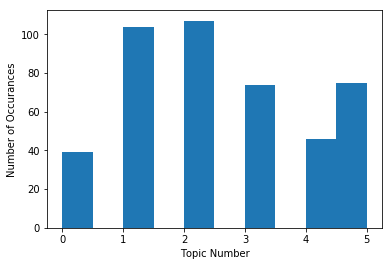

In [0]:
plt.ylabel("Number of Occurances")
plt.xlabel("Topic Number")
plt.hist(fourthquartile['Topic Final'])
plt.show()

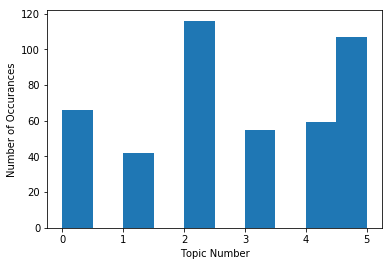

In [0]:
plt.ylabel("Number of Occurances")
plt.xlabel("Topic Number")
plt.hist(firstquartile['Topic Final'])
plt.show()